In [14]:
using LinearAlgebra
using SparseArrays
using Plots
using Polynomials
using Statistics

# Exercise 1.2

##### a)

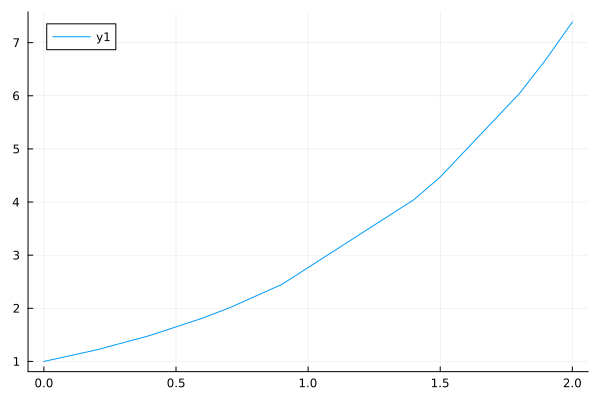

In [2]:
function BVP1D(c::Float64, d::Float64, x::Vector{Float64}) :: Vector{Float64}
    M = length(x)
    
    # Algorithm 1
    A = spzeros(M, M)
    b = zeros(M)

    for i in 1:M-1
        h = x[i+1] - x[i]
        k1 = 1/h + h/3
        k2 = -1/h + h/6

        A[i, i] += k1
        A[i, i+1] = k2
        A[i+1, i] = k2
        A[i+1, i+1] = k1
    end

    
    # Algorithm 2
    b[1] = c
    b[2] -= A[1,2] * c
    b[M-1] -= A[M-1,M] * d
    b[M] = d
    
    A[1,1] = 1
    A[1,2] = 0
    A[2,1] = 0
    A[M, M] = 1
    A[M-1, M] = 0
    A[M, M-1] = 0

    u = A \ b

    return u
end

c = 1.0
d = exp(2)
x = [0.0, 0.2, 0.4, 0.6, 0.7, 0.9, 1.4, 1.5, 1.8, 1.9, 2.0]
u = BVP1D(c, d, x)
plot(x, u)

##### b) and c)

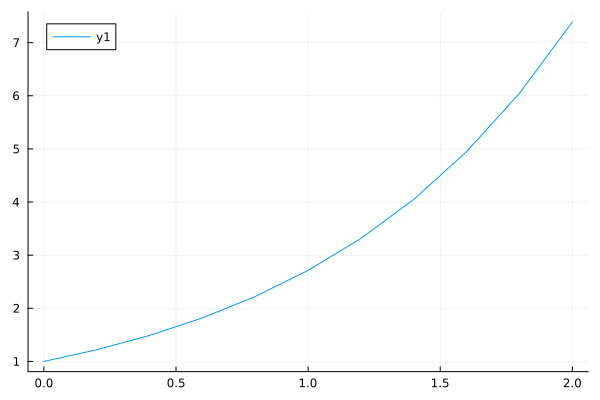

In [3]:
function BVP1D(c::Float64, d::Float64, L::Float64, M::UInt64) :: Tuple{Vector{Float64}, Vector{Float64}}
    x = collect(range(0, L, M))
    u = BVP1D(c, d, x)
    return u, x
end

c = 1.0
d = exp(2)
L = 2.0
M::UInt64 = 11

u, x = BVP1D(c, d, L, M)
plot(x, u)

In [4]:
function uhat(x::Float64, xs::Vector{Float64}, us::Vector{Float64}) :: Float64
    i = max(searchsortedfirst(xs, x) - 1, 1)
    h = xs[i+1] - xs[i]
    
    N1 = 1 - (x - xs[i]) / h
    N2 = (x - xs[i]) / h

    return us[i] * N1 + us[i+1] * N2
end

function uhat(x::Vector{Float64}, xs::Vector{Float64}, us::Vector{Float64}) :: Vector{Float64}
    return uhat.(x, Ref(xs), Ref(us))
end


uhat (generic function with 2 methods)

##### d)

2.0006860815877427

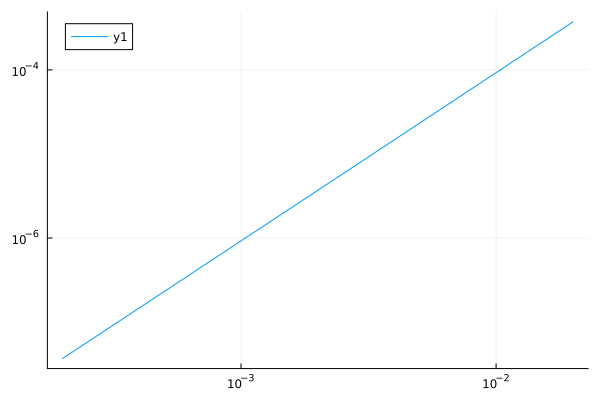

In [5]:
x_values = collect(range(0, stop=L, length=1000000))
N = 100
hs = zeros(N)
max_errors = zeros(N)
for i in 1:N
    M = i*N
    u_coefs, x_points = BVP1D(c,d,L,M)
    errors = abs.(exp.(x_values)-uhat(x_values,x_points,u_coefs))
    hs[i] = L/M
    max_errors[i] = maximum(errors)
end

coefficients = fit(log.(hs), log.(max_errors), 1)[1]
print(coefficients)
plot(hs ,max_errors, xscale=:log10, yscale=:log10)

# Exercise 1.5

##### d)

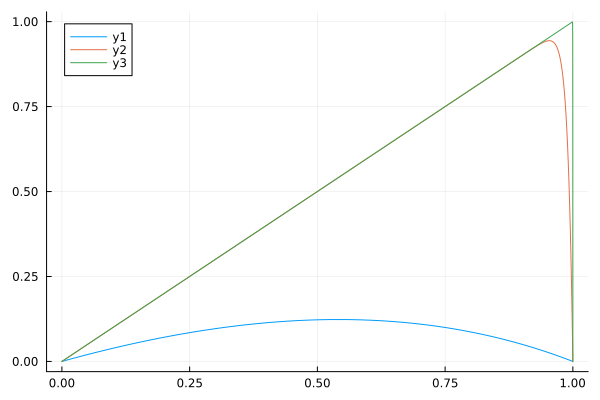

In [6]:
u_analytical(x,eps,psi) = 1/psi * (x - (exp((x-1)*psi/eps) - exp(-psi/eps))/(1 - exp(-psi/eps)))
xs = range(0,1,10000)
plot(xs,u_analytical.(xs,1,1))
plot!(xs,u_analytical.(xs,0.01,1))
plot!(xs,u_analytical.(xs,0.0001,1))



##### e)

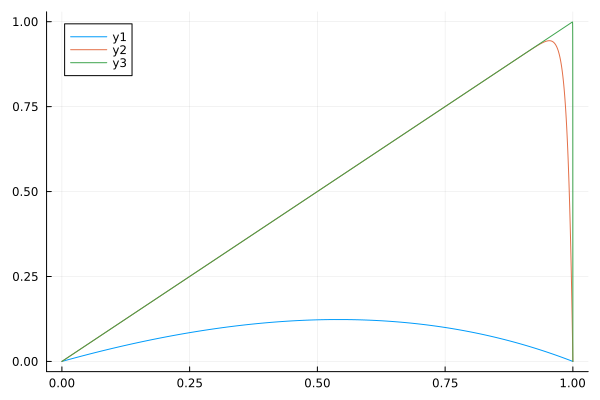

0.817819318758991

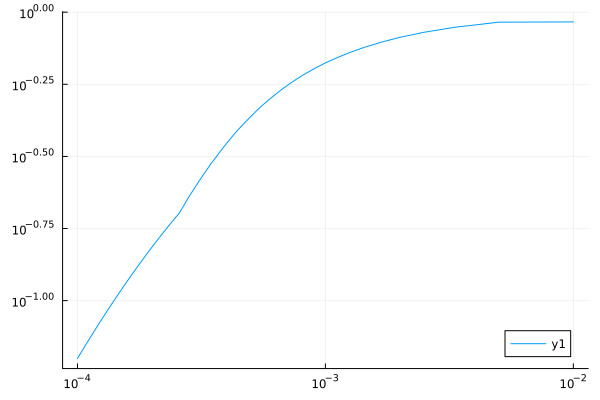

In [7]:
function LADE1D(eps::Float64, psi::Float64, x::Vector{Float64}) :: Vector{Float64}
    M = length(x)
    
    # Algorithm 1
    A = spzeros(M, M)
    b = zeros(M)

    for i in 1:M-1
        h = x[i+1] - x[i]
        k11 = eps/h + psi/2
        k12 = -eps/h + psi/2
        k21 = -eps/h - psi/2
        k22 = eps/h - psi/2

        A[i, i] += k11
        A[i, i+1] = k12
        A[i+1, i] = k21
        A[i+1, i+1] = k22
    end

    
    # Algorithm 2
    for i in 2:M-1
        b[i] = (x[i+1]-x[i-1])/2
    end
    
    A[1,1] = 1
    A[1,2] = 0
    A[2,1] = 0
    A[M, M] = 1
    A[M-1, M] = 0
    A[M, M-1] = 0

    u = A \ b

    return u
end

function LADE1D(eps::Float64, psi::Float64, L::Float64, M::UInt64) :: Tuple{Vector{Float64}, Vector{Float64}}
    x = collect(range(0, L, M))
    u = LADE1D(eps,psi,x)
    return u, x
end

xs = collect(range(0,1,20000))
x_points = collect(range(0,1,10000))

p1 = plot(xs,uhat(xs,x_points,LADE1D(1.0,1.0,x_points)))
#plot!(xs,u_analytical.(xs,1,1)) # not good
plot!(xs,uhat(xs,x_points,LADE1D(0.01,1.0,x_points)))
plot!(xs,uhat(xs,x_points,LADE1D(0.0001,1.0,x_points)))
display(p1)
# FEM is not happy when epsilon small :(

L = 1.0
epsilon = 0.0001
x_values = collect(range(0, stop=L, length=1000000))
N = 100
hs = zeros(N)
max_errors = zeros(N)
for i in 1:N
    M = i*N
    u_coefs, x_points = LADE1D(epsilon,1.0,L,M)
    errors = abs.(u_analytical.(x_values,epsilon,1.0)-uhat(x_values,x_points,u_coefs))
    hs[i] = L/M
    max_errors[i] = maximum(errors)
end

coefficients = fit(log.(hs), log.(max_errors), 1)[1]
display(coefficients)
plot(hs ,max_errors, xscale=:log10, yscale=:log10)



# Exercise 1.6

##### a)

3-element Vector{Float64}:
 0.004767772206758015
 0.022841409659382403
 0.05083594711288536

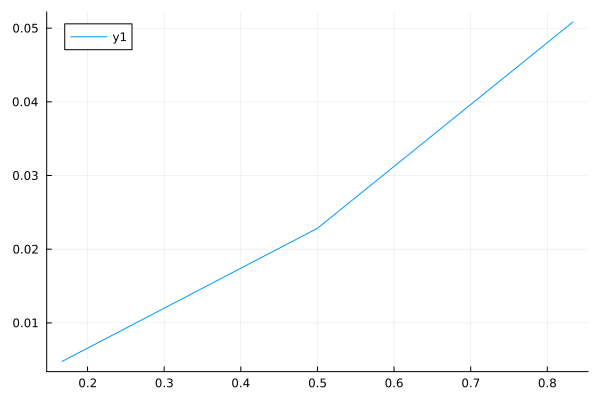

In [2]:
u_analytical(x) = exp(-800*(x-0.4)^2)+0.25*exp(-40*(x-0.8)^2)

function compute_error_decrease(fun::Function,VX::Vector{Float64},EToV::Matrix{Int64}) :: Vector{Float64}
    M = length(VX)
    errors = zeros(M-1)
    for i in 1:M-1
        hi = VX[i+1]-VX[i]
        xi = VX[i]
        errors[i] = sqrt(3)*sqrt(hi*(-2*fun(xi+hi/2)+fun(xi)+fun(xi+hi))^2)/6
    end
    return errors
end

M = 4
VX = collect(range(0,1,M))
EToV = hcat(1:M-1,2:M)
errors = compute_error_decrease(u_analytical,VX,EToV)

idk = (VX[1:M-1]+VX[2:M])/2
display(errors)
display(plot(idk,errors))

##### b)

In [3]:
function refine_marked(EToVcoarse::Matrix{Int64}, xcoarse::Vector{Float64}, idxMarked::Vector{Int64})::Tuple{Matrix{Int64}, Vector{Float64}}
    M, N = size(EToVcoarse)
    K = length(idxMarked)

    EToVfine = zeros((M + K, N))
    xfine = zeros(length(xcoarse) + K)

    i = 1
    for j in 1:M
        xfine[j+i-1] = xcoarse[j]
        EToVfine[j+i-1, :] = [j+i-1, j+i]

        if i <= length(idxMarked) && idxMarked[i] == j
            xfine[j+i] = (xcoarse[j+1] + xcoarse[j])/2
            EToVfine[j+i, :] = [j+i, j+i+1]
            i += 1
        end
    end

    xfine[end] = xcoarse[end]

    return EToVfine, xfine
end

idxMarked = [1,2,3]
refine_marked(EToV, VX, idxMarked)

([1 2; 2 3; … ; 5 6; 6 7], [0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333333, 1.0])

##### c)

In [26]:
count = 0
M = 3
VX = collect(range(0,1,M))
EToV = hcat(1:M-1,2:M)
errors = compute_error_decrease(u_analytical,VX,EToV)
idxMarked = findall(errors .>= 1.0e-4)
mean_errors = []
DOFs = []
while !isempty(idxMarked)
    push!(mean_errors,mean(errors))
    push!(DOFs,length(VX))
    EToV,VX = refine_marked(EToV,VX,idxMarked)
    errors = compute_error_decrease(u_analytical,VX,EToV)
    idxMarked = findall(errors .>= 1.0e-4)
    count += 1
end

display(count)
display(length(VX))


8

69

##### d)

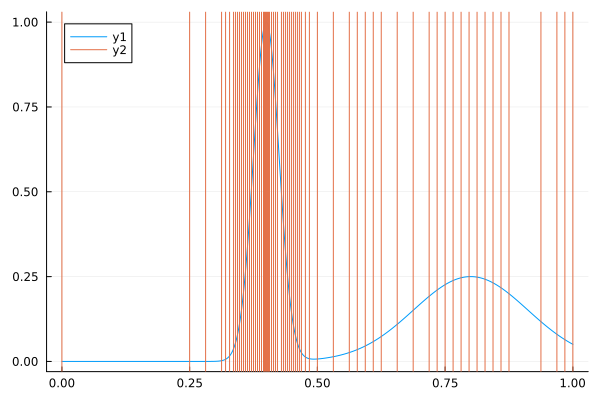

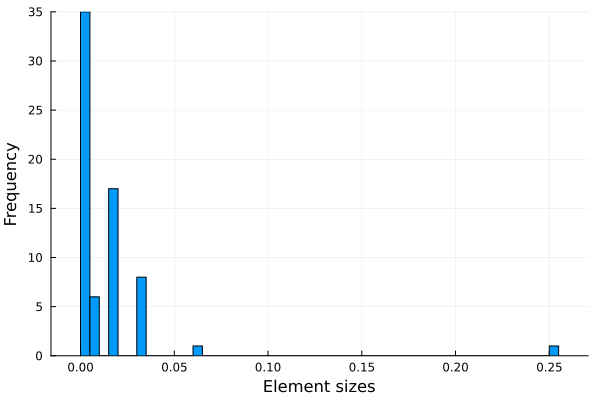

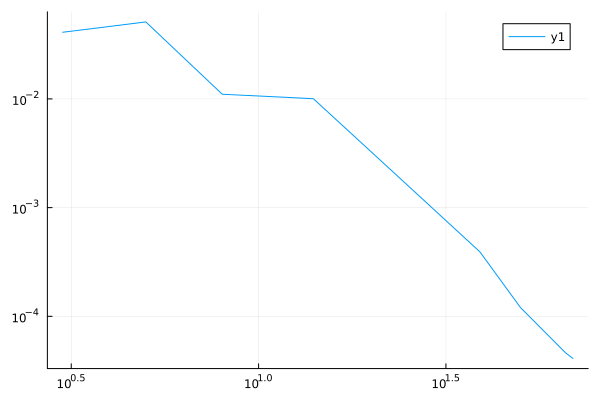

In [25]:
x = collect(range(0, 1, 10000))
p = plot(x, u_analytical.(x))
vline!(VX)
display(p)

hs = VX[2:end] - VX[1:end-1]
display(histogram(hs, bins=100, xlabel="Element sizes", ylabel="Frequency", legend=false))

display(plot(DOFs,mean_errors,xscale=:log10,yscale=:log10))

# Exercise 1.7

##### b)

In [62]:
function errorestimate(xc,xf,uhc,uhf,EToVc,EToVf,idxNew)
    M,N = size(EToVc)
    K = length(idxNew)
    errors = zeros(M)
    for k in 1:K
        i = idxNew[k]
        j = i+k-1
        h = uhc[i+1] - uhc[i]
        uc1 = uhc[i]
        uc2 = uhc[i+1]
        uf1 = uhf[j]
        uf2 = uhf[j+1]
        uf3 = uhf[j+2]
        # can probably be simplied a little
        errors[i] = sqrt(abs(h*(uc1^2 + (uc2 - (5*uf1)/4 - (3*uf2)/2 - uf3/4)*uc1 + uc2^2 + ((-uf1/2 - 3*uf2 - (5*uf3)/2)*uc2)/2 + uf2^2 + ((uf1 + uf3)*uf2)/2 + uf1^2/2 + uf3^2/2)/3))
    end
    return errors
end


errorestimate (generic function with 1 method)

##### c)

In [63]:
# copied from 1.6.b
function refine_marked(EToVcoarse::Matrix{Int64}, xcoarse::Vector{Float64}, idxMarked::Vector{Int64})::Tuple{Matrix{Int64}, Vector{Float64}}
    M, N = size(EToVcoarse)
    K = length(idxMarked)

    EToVfine = zeros((M + K, N))
    xfine = zeros(length(xcoarse) + K)

    i = 1
    for j in 1:M
        xfine[j+i-1] = xcoarse[j]
        EToVfine[j+i-1, :] = [j+i-1, j+i]

        if i <= length(idxMarked) && idxMarked[i] == j
            xfine[j+i] = (xcoarse[j+1] + xcoarse[j])/2
            EToVfine[j+i, :] = [j+i, j+i+1]
            i += 1
        end
    end

    xfine[end] = xcoarse[end]

    return EToVfine, xfine
end

# from earlier
function uhat(x::Float64, xs::Vector{Float64}, us::Vector{Float64}) :: Float64
    i = max(searchsortedfirst(xs, x) - 1, 1)
    h = xs[i+1] - xs[i]
    
    N1 = 1 - (x - xs[i]) / h
    N2 = (x - xs[i]) / h

    return us[i] * N1 + us[i+1] * N2
end

function uhat(x::Vector{Float64}, xs::Vector{Float64}, us::Vector{Float64}) :: Vector{Float64}
    return uhat.(x, Ref(xs), Ref(us))
end

uhat (generic function with 2 methods)

##### e)

In [64]:
function BVP1D(c::Float64, d::Float64, x::Vector{Float64}, fun::Function) :: Vector{Float64}
    M = length(x)
    
    # Algorithm 1
    A = spzeros(M, M)
    b = zeros(M)

    for i in 1:M-1
        h = x[i+1] - x[i]
        k1 = 1/h + h/3
        k2 = -1/h + h/6

        A[i, i] += k1
        A[i, i+1] = k2
        A[i+1, i] = k2
        A[i+1, i+1] = k1
    end

    
    # Algorithm 2
    for i in 2:M-1
        h1 = x[i]-x[i-1]
        h2 = x[i+1]-x[i]
        b[i] = -fun(x[i-1])*h1/6 - fun(x[i])*h1/3 - fun(x[i])*h2/3 - fun(x[i+1])*h2/6
    end

    b[1] = c
    b[2] -= A[1,2] * c
    b[M-1] -= A[M-1,M] * d
    b[M] = d
    
    A[1,1] = 1
    A[1,2] = 0
    A[2,1] = 0
    A[M, M] = 1
    A[M-1, M] = 0
    A[M, M-1] = 0

    u = A \ b

    return u
end

function BVP1D(c::Float64, d::Float64, L::Float64, M::Int64, fun::Function) :: Tuple{Vector{Float64}, Vector{Float64}}
    x = collect(range(0, L, M))
    f = fun.(x)
    u = BVP1D(c, d, x, f)
    return u, x
end

BVP1D (generic function with 5 methods)

##### f)

1.999616275161032

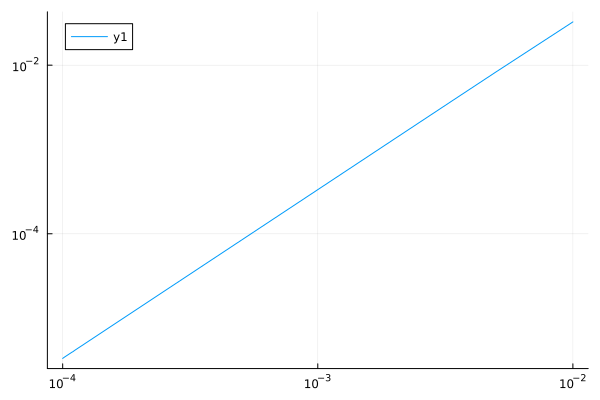

In [65]:
u_analytical(x) = exp(-800*(x - 0.4)^2) + 0.25*exp(-40*(x - 0.8)^2)
f_analytical(x) = -1601*exp(-800*(x - 0.4)^2) + (-1600*x + 640.0)^2*exp(-800*(x - 0.4)^2) - 20.25*exp(-40*(x - 0.8)^2) + 0.25*(-80*x + 64.0)^2*exp(-40*(x - 0.8)^2)
c = 0.0
d = 0.05047412950
L = 1.0
x_values = collect(range(0, stop=L, length=100000))
N = 100
hs = zeros(N)
max_errors = zeros(N)
for i in 1:N
    M = i*N
    u_coefs, x_points = BVP1D(c,d,L,M,f_analytical)
    errors = abs.(u_analytical.(x_values)-uhat(x_values,x_points,u_coefs))
    hs[i] = L/M
    max_errors[i] = maximum(errors)
end


coefficients = fit(log.(hs), log.(max_errors), 1)[1]
print(coefficients)
plot(hs ,max_errors, xscale=:log10, yscale=:log10)

In [67]:
M = 3
xc = collect(range(0,1,M))
EToVc = hcat(1:M-1,2:M)
EToVf, xf = refine_marked(EToVc,xc,collect(1:length(xc)-1))
uc = BVP1D(c,d,xc,f_analytical)
uf = BVP1D(c,d,xf,f_analytical)
errors = errorestimate(xc,xf,uc,uf,EToVc,EToVf,collect(1:length(xc)-1))
idxMarked = findall(errors .>= 10e-4)
xc, EToVc = refine_marked(EToVc,xc,idxMarked)
while !isempty(idxMarked)
    EToVf, xf = refine_marked(EToVc,xc,collect(1:length(xc)-1))
    uc = BVP1D(c,d,xc,f_analytical)
    uf = BVP1D(c,d,xf,f_analytical)
    errors = errorestimate(xc,xf,uc,uf,EToVc,EToVf,collect(1:length(xc)-1))
    idxMarked = findall(errors .>= 10e-4)
    xc, EToVc = refine_marked(EToVc,xc,idxMarked)
end


1

2

3

4

([1 2; 2 3; 3 4; 4 5], [0.0, 0.25, 0.5, 0.75, 1.0])